In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from google.colab import drive

drive.mount('/content/drive')
start_time = time.time()
!cp -r "/content/drive/MyDrive/ML Project/dataset" /content/dataset
print(f"Data copied in {time.time() - start_time:.2f} seconds.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data copied in 33.11 seconds.


In [ ]:
# --- 1. SETUP AND DATA PREPARATION ---

DATA_DIR = "/content/dataset"
IMG_SIZE = 128
CATEGORIES = ['normal', 'cataract', 'diabetic_retinopathy', 'glaucoma']
NUM_CLASSES = len(CATEGORIES)

def load_and_process_data():
    """Loads and processes image data using OpenCV."""
    data = []
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(DATA_DIR, category)
        if not os.path.isdir(path):
            print(f"Error: Directory not found at {path}")
            continue
        print(f"Loading category: {category} ({i})")
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, i])
            except Exception as e:
                print(f"  Error loading image {img_path}: {e}")
    X, y = [], []
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y)
    return X, y

# Load all the data
X, y = load_and_process_data()
print(f"\nLoaded {len(X)} total images.")

Loading category: normal (0)
Loading category: cataract (1)
Loading category: diabetic_retinopathy (2)
Loading category: glaucoma (3)

Loaded 4217 total images.


In [ ]:
# --- 2. MODEL EVALUATION WITH 10-FOLD CROSS-VALIDATION ---

def create_model():
    """Creates and compiles a new instance of the CNN model."""
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
acc_per_fold = []
fold_no = 1

print("\n--- Starting 10-Fold Cross-Validation ---")
for train_index, test_index in kfold.split(X, y):
    model = create_model()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f'Training for fold {fold_no}...')
    model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=0)

    scores = model.evaluate(X_test, y_test, verbose=1)
    acc_per_fold.append(scores[1] * 100)

    # Store predictions and true labels from the last fold for the confusion matrix
    if fold_no == 10:
        y_pred_probs = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred_probs, axis=1)
        cm_y_true = y_test
        cm_y_pred = y_pred_labels

    fold_no += 1


--- Starting 10-Fold Cross-Validation ---
Training for fold 1...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8848 - loss: 0.5435
Training for fold 2...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9095 - loss: 0.6012
Training for fold 3...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8609 - loss: 0.6326
Training for fold 4...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8574 - loss: 0.7690
Training for fold 5...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8603 - loss: 0.5523
Training for fold 6...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8889 - loss: 0.6188
Training for fold 7...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8729 - loss: 0.9180
Training for fold 8...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9095 - loss: 0.4111
Training for fold 9...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8878 - loss: 0.8275
Training for fold 10...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8751 -


--- Cross-Validation Results ---
Average Accuracy: 87.79% (+- 1.69%)


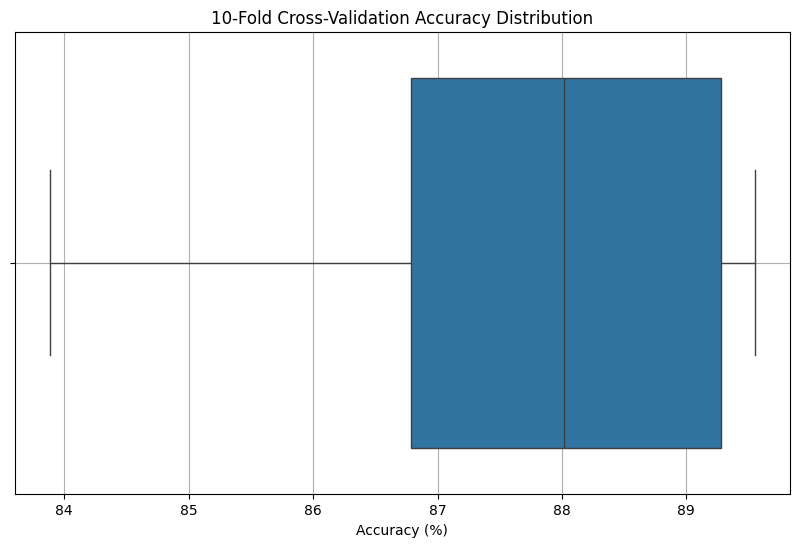


--- Confusion Matrix (from last fold) ---


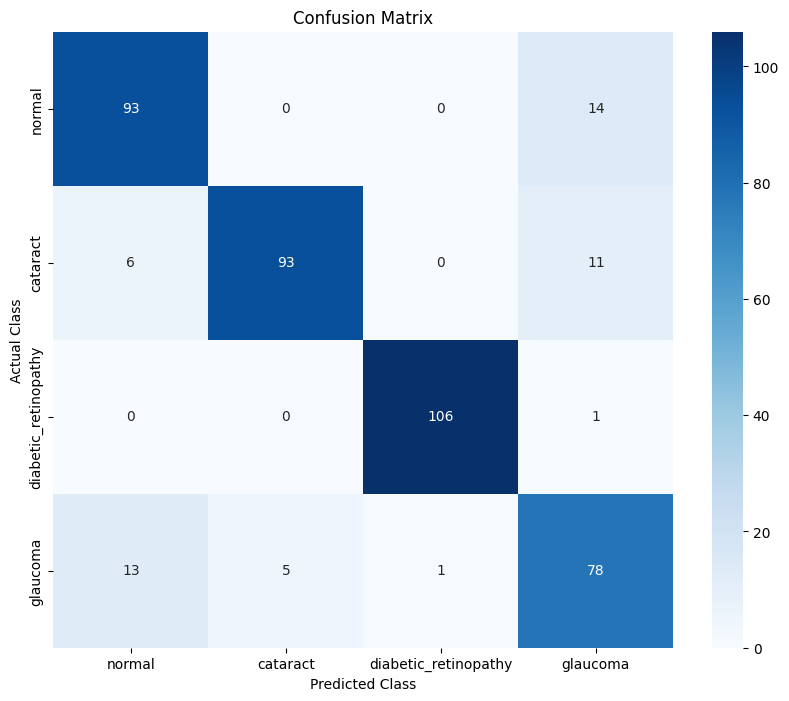

In [ ]:
# --- 3. VISUALIZE THE RESULTS ---

# 3a. Box Plot of Cross-Validation Accuracies
print("\n--- Cross-Validation Results ---")
print(f'Average Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)')

plt.figure(figsize=(10, 6))
sns.boxplot(x=acc_per_fold)
plt.title('10-Fold Cross-Validation Accuracy Distribution')
plt.xlabel('Accuracy (%)')
plt.grid(True)
plt.show()

# 3b. Confusion Matrix from the last fold
print("\n--- Confusion Matrix (from last fold) ---")
cm = confusion_matrix(cm_y_true, cm_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# --- 4. TRAIN AND SAVE THE FINAL MODEL ---

print("\n--- Training Final Model on All Data ---")
final_model = create_model()
final_model.fit(X, y, batch_size=32, epochs=50, verbose=1)

print("\nFinal model training complete.")
final_model.save('eye_disease_model.h5')
print("\nFinal deployable model saved as 'eye_disease_model.h5'")


--- Training Final Model on All Data ---
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4547 - loss: 1.1709
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6337 - loss: 0.7797
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7176 - loss: 0.6390
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7786 - loss: 0.5394
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7844 - loss: 0.5119
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8129 - loss: 0.4666
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8233 - loss: 0.4284
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8279 - loss: 0.4194
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8358 - loss: 0.4071
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8626 - loss: 0.3717
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8614 - loss: 0.3531


Final model training complete.

Final deployable model saved as 'eye_disease_model.h5'
